# Fraud Detection

**Problem Statement -**
```
Digital payments are evolving, but so are cyber criminals.
According to the Data Breach Index, more than 5 million records are being stolen on a daily basis, a concerning statistic that shows - fraud is still very common both for Card-Present and Card-not Present type of payments.

In today’s digital world where trillions of Card transaction happens per day, detection of fraud is challenging.

As fraudster change tactics, learning algorithm can be improvised adding more analyzed features  

As a data scientist, you are required to construct a ML model based on the available data and justify how mature your model is for industry (bank- payment gateways or VISA / Mastercard) in categorization & authorization of transaction based on efficiency in fraud detection.

•	Explore other performance characteristics like accuracy, specificity, the area under the precision-recall curve, confusion matric etc. on the given dataset.

•	Identify all possible features critical in the identification of card frauds.
```

In [1]:
# Importing required libraries

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, plot_precision_recall_curve

In [2]:
def visualize_conf_mat(classifier_name, confusion_mat):
    plt.figure(figsize=(10,6))
    sns.heatmap(confusion_mat, 
                cmap='icefire', 
                annot=True,
                fmt='d',
                xticklabels=['Predicted 0s', 'Predicted 1s'],
                yticklabels=['Actual 0s', 'Actual 1s'])
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.title(classifier_name + ' Confusion Matrix')
    plt.show()

In [3]:
def classifier_model_eval(classifier_name, y_real, y_pred):
    conf_mat = confusion_matrix(y_real, y_pred)
    visualize_conf_mat(classifier_name, conf_mat)
    print(classifier_name)
    TN, FP, FN, TP = conf_mat.flatten()
    print("True Negatives  : ", TN)
    print("False Positives : ", FP)
    print("False Negatives : ", FN)
    print("True Positives  : ", TP)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    f1_score = (2 * precision * sensitivity) / (precision + sensitivity)
    print("Sensitivity (Recall) : ", sensitivity)
    print("Specificity : ", specificity)
    print("Precision   : ", precision)
    print("F1-Score    : ", f1_score)

In [4]:
# Reading card transaction data from CSV file
df = pd.read_csv("card_transdata.csv")

# Exploratory Data Analysis

In [5]:
# Visualizing the dataframe
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [6]:
# Column names available
df.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

**Looking at the dataset we can say that this is a labeled dataset hence this problem is fit for supervised learning**

**There are 7 independent variables or features or input variables ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']**

**Here dependent variable is ['fraud']**


In [7]:
# Number of rows and columns 
df.shape

(1000000, 8)

In [8]:
# Exploring the features available in dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB
None


In [9]:
# Checking the unique value for 'fraud' column
df.fraud.unique()

array([0., 1.])

In [10]:
# Checking the unique value for 'repeat_retailer' column
df.repeat_retailer.unique()

array([1., 0.])

In [11]:
# Checking the unique value for 'used_chip' column
df.used_chip.unique()

array([1., 0.])

In [12]:
# Checking the unique value for 'used_pin_number' column
df.used_pin_number.unique()

array([0., 1.])

In [13]:
# Checking the unique value for 'online_order' column
df.online_order.unique()

array([0., 1.])

**There are 8 columns and 1000000 Rows.**

**All the columns are having the same Datatype i.e., float64.**

**Just by looking at the data it is clear the ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'] are continuous numerical variables.**

**By checking the unique values for ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud'] it is clear that these are Binary variables.**

**Since dependent variable 'fraud' is just having two unique values [0, 1] it’s safe to say that this is a binary classification problem.**

In [14]:
# Describing the data
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


**Looking at the 5-point summary from above descriptive statistics it's clear that ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'] have outliers.**

**Normally we can handle the outliers by deleting them but since in this scenario there is a high chance that these so-called outliers are really not outliers and may contain some very useful information for detecting the fraud transactions.**

**So, we will not delete these outliers and instead include these for training of our model.**


In [15]:
# Checking for Missing values
df.isna().any()

distance_from_home                False
distance_from_last_transaction    False
ratio_to_median_purchase_price    False
repeat_retailer                   False
used_chip                         False
used_pin_number                   False
online_order                      False
fraud                             False
dtype: bool

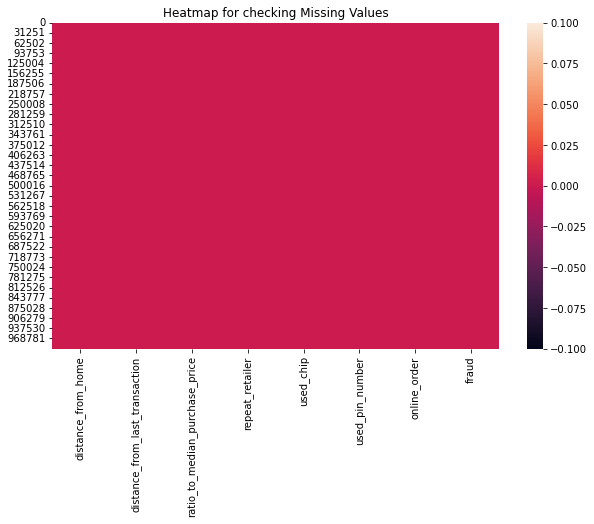

In [16]:
# Visualizing Missing values
plt.figure(figsize=(10,6))
sns.heatmap(df.isna())
plt.title('Heatmap for checking Missing Values')
plt.show()

**•	After verifying and looking at the heatmap above, we can say that there are no missing records in the dataset.**

In [17]:
# Checking for any duplicate transaction rows 
df.duplicated().any()

False

**From the above analysis, we can say that there are no duplicate records in the dataset.**

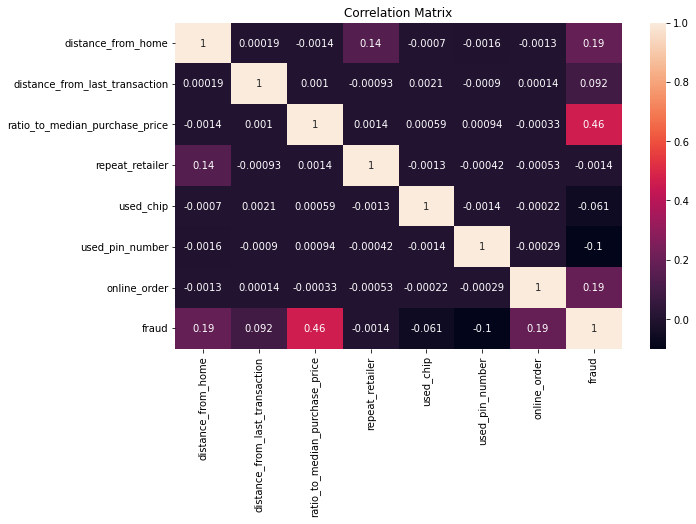

In [18]:
# Checking for Correlation 
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

**From the correlation matrix above , we can say that no feature column is highly correlated to each other hence there is no multicollinearity. The performance of some algorithms can deteriorate if two or more variables are tightly related.**

**We are also interested in the correlation between input variables with the output variable in order provide insight into which variables may or may not be relevant as input for developing a model.**

**'ratio_to_median_purchase_price' is having a good correlation with the output variable 'fraud' hence looks like a important feature for training a good model on the other hand 'repeat_retailer' column shows very low correlation with the output variable which means this could possibly not so important feature for training a model.**

In [19]:
# Number of Fraud and Non-Fraud class transactions
class_count = df['fraud'].value_counts()
print(class_count)

0.0    912597
1.0     87403
Name: fraud, dtype: int64


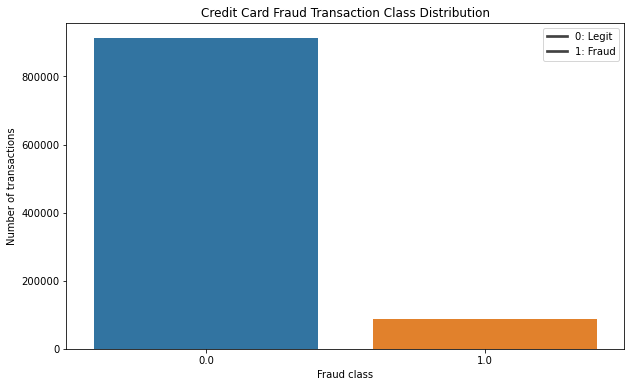

In [20]:
# Visualizng Fraud and Non-Fraud class transactions
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(class_count.index, class_count.values)
ax.set_title('Credit Card Fraud Transaction Class Distribution')
ax.set_xlabel('Fraud class')
ax.set_ylabel('Number of transactions')
ax.legend(labels=['0: Legit', '1: Fraud'])
plt.show()

In [21]:
# Ratio of Fraud and Non-Fraud class transactions
print(class_count / df.shape[0])

0.0    0.912597
1.0    0.087403
Name: fraud, dtype: float64


**From the above analysis, we can say that the number of legitimate transactions is extremely higher and Fraud occurrences are unfortunately an extreme minority in these transactions.**

**This is expected because fraud detection is one of the problem domains where the class distribution is inherently imbalanced. If the fraudulent transactions happened to be higher the legitimate ones it indicates that we were facing serious security breaches.**

**However, Machine Learning algorithms usually work best when the different classes contained in the dataset are almost equally present.**

**If there are few cases of fraud, then there's little data to learn how to identify them.**

**This is known as class imbalance, and it's one of the main challenges of fraud detection.**


In [22]:
# Taking a random sample of our data
# Since it is very time consuming and difficult to understand 1 million records on a graph 
# we take a random sample of 10,000 points 
df_sample = df.sample(n=10000)

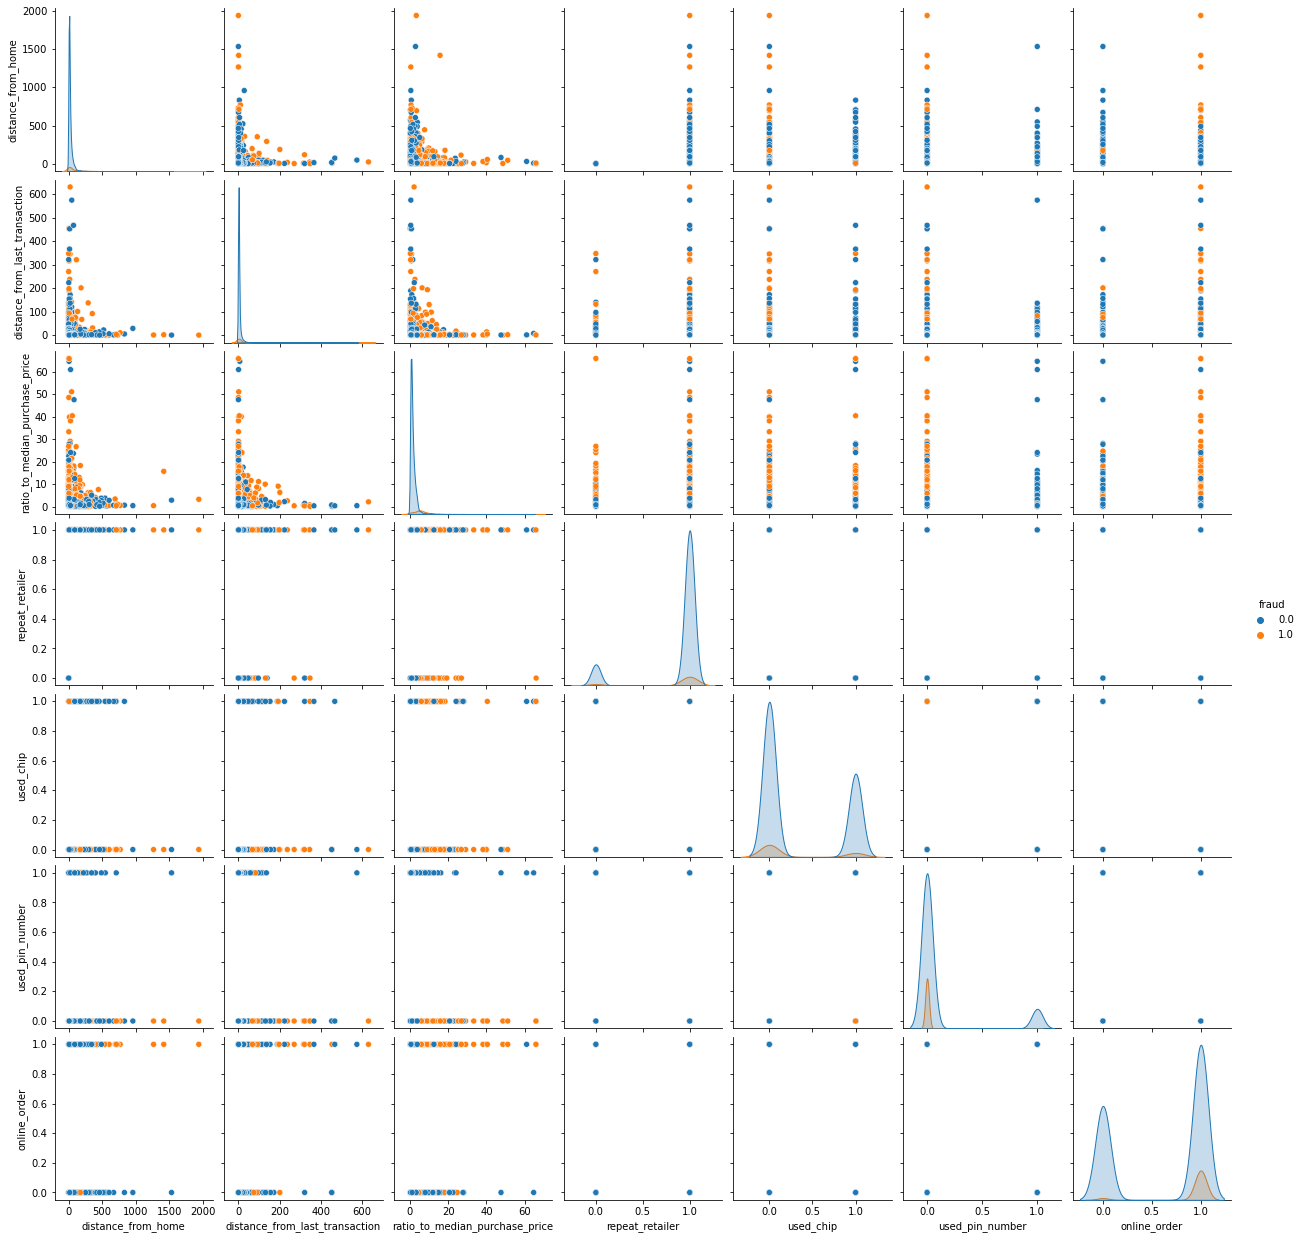

In [23]:
# Pairplot
sns.pairplot(df_sample, hue ='fraud')
plt.show()

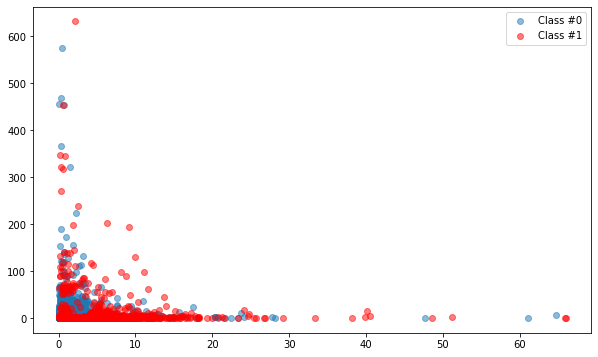

In [24]:
# Visualizing the spread of fraud and legit transaction data
plt.figure(figsize=(10,6))
plt.scatter(df_sample.ratio_to_median_purchase_price[df.fraud==0], df_sample.distance_from_last_transaction[df.fraud==0], alpha=0.5, label="Class #0")
plt.scatter(df_sample.ratio_to_median_purchase_price[df.fraud==1], df_sample.distance_from_last_transaction[df.fraud==1], alpha=0.5, label="Class #1", c='r')
plt.legend()
plt.show()

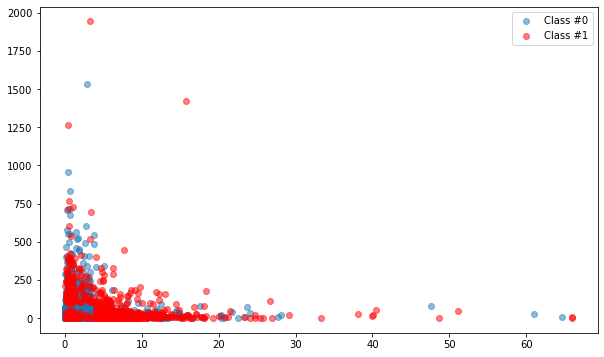

In [25]:
# Visualizing the spread of fraud and legit transaction data
plt.figure(figsize=(10,6))
plt.scatter(df_sample.ratio_to_median_purchase_price[df.fraud==0], df_sample.distance_from_home[df.fraud==0], alpha=0.5, label="Class #0")
plt.scatter(df_sample.ratio_to_median_purchase_price[df.fraud==1], df_sample.distance_from_home[df.fraud==1], alpha=0.5, label="Class #1", c='r')
plt.legend()
plt.show()

**By visualizing the data, we can say fraud cases are scattered all over our data and not easily separable.**

# Preprocessing of data

```
From the Exploratory Data Analysis performed above, we can observe that the number of fraudulent transactions is relatively rare. It only makes up about 8.7% of the entire transactions. 

This is super imbalanced. 

If we take this proportion as a baseline model, we will get a pretty high accuracy of 91.3% by creating a model which just predicts everything to be 0 whatever input data comes in. 
But this will fail to capture the minority class, although typically it is the model performance on the minority class which is the most important.

To summarize, in a dataset with highly imbalanced cases, accuracy score can be misleading because a high accuracy rate is achieved not because our model is any good but simply because the classifier algorithm will always predict the majority class without performing any analysis of the features.

So, we need to find a way to handle the imbalanced data problem.
```

**Resampling can help model performance in cases of imbalanced data sets.**

**1. Undersampling**

    Undersampling the majority class (non-fraud cases)
    * Take random draws from the non-fraud observations, to match the occurences of fraud observations.


**2. Oversampling**

    Oversampling the minority class (fraud cases)
    * Take random draws from the fraud cases and copy those observations to increase the amount of fraud samples.
    
```Both methods lead to having a balance between fraud and non-fraud cases```

**Drawbacks**
* with random undersampling, a lot of information is thrown away
* with oversampling, the model will be trained on a lot of duplicates


**Determining the best resampling method**

**Random Undersampling (RUS):**
```
* If there is a lot of data and many minority cases, then undersampling may be computationally more convenient
* In most cases, throwing away data is not desirable
```

**Random Oversampling (ROS):**
```
* Straightforward
* Training the model on many duplicates
```

**Synthetic minority Oversampling Technique (SMOTE):**
```
* SMOTE uses characteristics of nearest neighbors of fraud cases to create new synthetic fraud cases
  avoids duplicating observations
* more sophisticated
* realistic data set
* only works well if the minority case features are similar
    * if fraud is spread through the data and not distinct, using nearest neighbors to create more fraud cases, 
    introduces noise into the data, as the nearest neighbors might not be fraud cases
```

**When to use resmapling methods**

* First, split the data into train and test sets
* Use resampling methods on the training set, not on the test set
* Test data should be free of duplicates and synthetic data 
* The goal is to produce a better model by providing balanced data
    * The goal is not to predict the synthetic samples

# Train Test split

In [26]:
# Assiging the values to X (Fetaures) and y (Class) values
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
# Checking X 
print(X[0:3])
# Checking y 
print(y[0:3])

[[57.87785658  0.31114001  1.94593998  1.          1.          0.
   0.        ]
 [10.8299427   0.1755915   1.29421881  1.          0.          0.
   0.        ]
 [ 5.09107949  0.80515259  0.42771456  1.          0.          0.
   1.        ]]
[0. 0. 0.]


In [27]:
# Splitting training and testing data
# Keeping testing data at 10% given we have a huge amount of data (1 million records)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [28]:
print('Original training dataset shape %s' % Counter(y_train))

Original training dataset shape Counter({0.0: 821300, 1.0: 78700})


In [29]:
print('Original testing dataset shape %s' % Counter(y_test))

Original testing dataset shape Counter({0.0: 91297, 1.0: 8703})


# Feature Scaling

In [30]:
# Checking traning data before scaling
print(X_train[0:3])
print(y_train[0:3])

[[20.19526981  0.19405767  2.18991191  1.          1.          0.
   1.        ]
 [22.72704693  7.10820705  0.40843434  1.          1.          0.
   0.        ]
 [16.23752567  3.97832068  1.10052799  1.          0.          0.
   1.        ]]
[0. 0. 0.]


In [31]:
# Checking testing data before scaling
print(X_test[0:3])
print(y_test[0:3])

[[0.92950939 1.29647686 0.36111028 0.         0.         0.
  1.        ]
 [0.61117907 0.20829461 3.11888423 0.         0.         0.
  1.        ]
 [3.95606203 0.52919374 1.57994211 1.         0.         0.
  0.        ]]
[0. 0. 0.]


In [32]:
# Standard feature scaling
sc = StandardScaler()
X_train[:, :] = sc.fit_transform(X_train[:, :])
X_test[:, :] = sc.transform(X_test[:, :])

In [33]:
# Checking traning data post scaling
print(X_train[0:3])
print(y_train[0:3])

[[-0.09927539 -0.18435468  0.13039206  0.36648113  1.36129066 -0.33457885
   0.73310066]
 [-0.060174    0.07942108 -0.50676744  0.36648113  1.36129066 -0.33457885
  -1.36406915]
 [-0.16039978 -0.03998452 -0.25923469  0.36648113 -0.73459697 -0.33457885
   0.73310066]]
[0. 0. 0.]


In [34]:
# Checking testing data post scaling
print(X_test[0:3])
print(y_test[0:3])

[[-0.39682058 -0.14229724 -0.52369327 -2.72865345 -0.73459697 -0.33457885
   0.73310066]
 [-0.40173696 -0.18381154  0.46264634 -2.72865345 -0.73459697 -0.33457885
   0.73310066]
 [-0.35007775 -0.17156919 -0.08776845  0.36648113 -0.73459697 -0.33457885
  -1.36406915]]
[0. 0. 0.]


# Undersampling - RUS

In [35]:
# Checking the shape of training dataset before resampling
print(X_train.shape)
print(y_train.shape)

(900000, 7)
(900000,)


In [36]:
print('Original training dataset shape %s' % Counter(y_train))

Original training dataset shape Counter({0.0: 821300, 1.0: 78700})


In [37]:
rus = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

In [38]:
print('Resampled training dataset shape %s' % Counter(y_train_us))

Resampled training dataset shape Counter({0.0: 78700, 1.0: 78700})


In [39]:
# Checking resampled traning data post scaling
print(X_train_us[0:3])
print(y_train_us[0:3])

[[ 3.05641644e-01 -1.88069960e-01  1.28502518e+00  3.66481130e-01
   1.36129066e+00  2.98883205e+00  7.33100662e-01]
 [-3.62909134e-01 -1.22628159e-01  6.94763463e-01  3.66481130e-01
   1.36129066e+00 -3.34578854e-01  7.33100662e-01]
 [-2.09466808e-03 -1.86293182e-01 -1.21858138e-01  3.66481130e-01
   1.36129066e+00  2.98883205e+00  7.33100662e-01]]
[0. 0. 0.]


In [40]:
# Checking the shape of training dataset after resampling
print(X_train_us.shape)
print(y_train_us.shape)

(157400, 7)
(157400,)


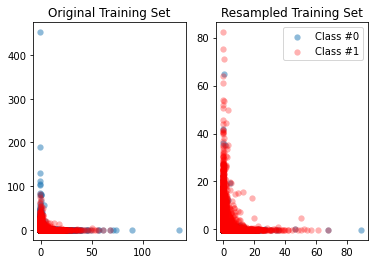

In [41]:
# Visualizing traning data before and after resampling
plt.subplot(1, 2, 1)
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label="Class #1", alpha=0.3, linewidth=0.15, c='r')
plt.title('Original Training Set')
plt.subplot(1, 2, 2)
plt.scatter(X_train_us[y_train_us == 0, 0], X_train_us[y_train_us == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X_train_us[y_train_us == 1, 0], X_train_us[y_train_us == 1, 1], label="Class #1", alpha=0.3, linewidth=0.15, c='r')
plt.title('Resampled Training Set')
plt.legend()
plt.show()

## Logist Regression Model - Undersampling

In [42]:
# Logistic Regression Training
model_lgr_under = LogisticRegression()
model_lgr_under.fit(X_train_us, y_train_us)

LogisticRegression()

In [43]:
# Logistic Regression Prediction
y_pred_lgr_under = model_lgr_under.predict(X_test)

**Model Evaluation**

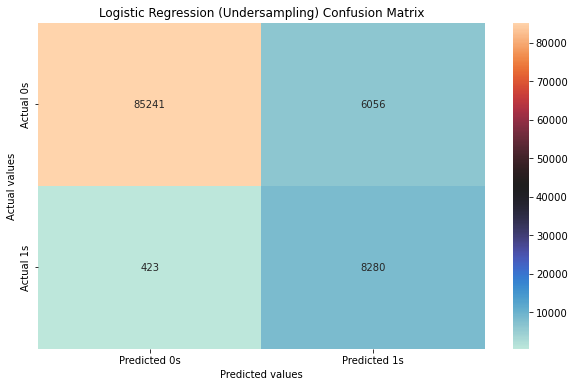

Logistic Regression (Undersampling)
True Negatives  :  85241
False Positives :  6056
False Negatives :  423
True Positives  :  8280
Sensitivity (Recall) :  0.9513960703205792
Specificity :  0.9336670427286767
Precision   :  0.5775669642857143
F1-Score    :  0.7187811971005685


In [44]:
# Model evaluation - Confusion matrix, Sensitivity, Specificity, Precision and F1-score
classifier_model_eval('Logistic Regression (Undersampling)', y_test, y_pred_lgr_under)

In [45]:
# Model evaluation - accuracy 
train_lgr_under_accuracy = model_lgr_under.score(X_train_us, y_train_us)
test_lgr_under_accuracy = model_lgr_under.score(X_test, y_test)
print("Logistic Regression (Undersampling):")
print("Training Accuracy - ", train_lgr_under_accuracy)
print("Testing Accuracy  - ", test_lgr_under_accuracy)

Logistic Regression (Undersampling):
Training Accuracy -  0.9410165184243965
Testing Accuracy  -  0.93521


In [46]:
# Model evaluation - AUC
training_lgr_under_AUC = roc_auc_score(y_train_us, model_lgr_under.predict_proba(X_train_us)[:, 1]) 
testing_lgr_under_AUC = roc_auc_score(y_test, model_lgr_under.predict_proba(X_test)[:, 1])
print("Logistic Regression (Undersampling):")
print("Training AUC : ", training_lgr_under_AUC)
print("Testing AUC  : ", testing_lgr_under_AUC)

Logistic Regression (Undersampling):
Training AUC :  0.9790180143016521
Testing AUC  :  0.9797212900275996


(0.0, 1.1)

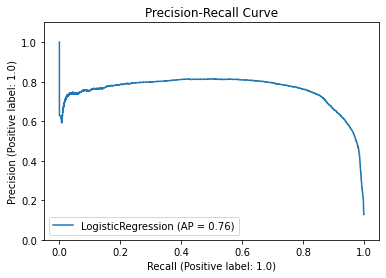

In [47]:
# Model evaluation - Precision Recall plot
disp_lgr_under = plot_precision_recall_curve(model_lgr_under, X_test, y_test)
disp_lgr_under.ax_.set_title('Precision-Recall Curve')
disp_lgr_under.ax_.set_ylim(0, 1.1)

## Decision Tree Classifier Model - Undersampling

In [48]:
# Decision Tree Training
model_dtc_under = DecisionTreeClassifier(criterion = 'entropy')
model_dtc_under.fit(X_train_us, y_train_us)

DecisionTreeClassifier(criterion='entropy')

In [49]:
# Decision Tree Prediction
y_pred_dtc_under = model_dtc_under.predict(X_test)

**Model Evaluation**

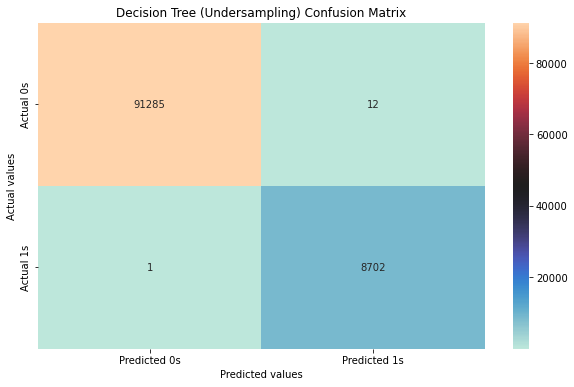

Decision Tree (Undersampling)
True Negatives  :  91285
False Positives :  12
False Negatives :  1
True Positives  :  8702
Sensitivity (Recall) :  0.9998850970929565
Specificity :  0.9998685608508494
Precision   :  0.9986229056690383
F1-Score    :  0.9992536028018603


In [50]:
# Model evaluation - Confusion matrix, Sensitivity, Specificity, Precision and F1-score
classifier_model_eval('Decision Tree (Undersampling)', y_test, y_pred_dtc_under)

In [51]:
# Model evaluation - accuracy 
train_dtc_under_accuracy = model_dtc_under.score(X_train_us, y_train_us)
test_dtc_under_accuracy = model_dtc_under.score(X_test, y_test)
print("Decision Tree (Undersampling):")
print("Training Accuracy - ", train_dtc_under_accuracy)
print("Testing Accuracy  - ", test_dtc_under_accuracy)

Decision Tree (Undersampling):
Training Accuracy -  1.0
Testing Accuracy  -  0.99987


In [52]:
# Model evaluation - AUC
training_dtc_under_AUC = roc_auc_score(y_train_us, model_dtc_under.predict_proba(X_train_us)[:, 1]) 
testing_dtc_under_AUC = roc_auc_score(y_test, model_dtc_under.predict_proba(X_test)[:, 1])
print("Decision Tree (Undersampling):")
print("Training AUC : ", training_dtc_under_AUC)
print("Testing AUC  : ", testing_dtc_under_AUC)

Decision Tree (Undersampling):
Training AUC :  1.0
Testing AUC  :  0.999876828971903


(0.0, 1.1)

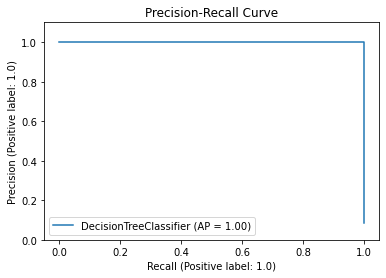

In [53]:
# Model evaluation - Precision Recall plot
disp_dtc_under = plot_precision_recall_curve(model_dtc_under, X_test, y_test)
disp_dtc_under.ax_.set_title('Precision-Recall Curve')
disp_dtc_under.ax_.set_ylim(0, 1.1)

## Random Forest Classifier Model - Undersampling

In [54]:
# Random forest training
model_rfc_under = RandomForestClassifier(n_estimators = 150, criterion = 'entropy')
model_rfc_under.fit(X_train_us, y_train_us)

RandomForestClassifier(criterion='entropy', n_estimators=150)

In [55]:
# Random forest Prediction
y_pred_rfc_under = model_rfc_under.predict(X_test)

**Model Evaluation**

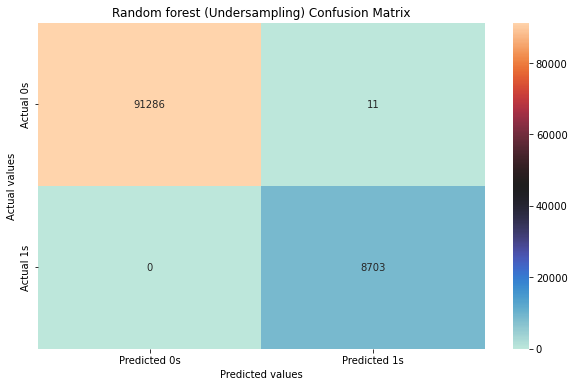

Random forest (Undersampling)
True Negatives  :  91286
False Positives :  11
False Negatives :  0
True Positives  :  8703
Sensitivity (Recall) :  1.0
Specificity :  0.9998795141132787
Precision   :  0.9987376635299517
F1-Score    :  0.9993684331400357


In [56]:
# Model evaluation - Confusion matrix, Sensitivity, Specificity, Precision and F1-score
classifier_model_eval('Random forest (Undersampling)', y_test, y_pred_rfc_under)

In [57]:
# Model evaluation - accuracy 
train_rfc_under_accuracy = model_rfc_under.score(X_train_us, y_train_us)
test_rfc_under_accuracy = model_rfc_under.score(X_test, y_test)
print("Random forest (Undersampling):")
print("Training Accuracy - ", train_rfc_under_accuracy)
print("Testing Accuracy  - ", test_rfc_under_accuracy)

Random forest (Undersampling):
Training Accuracy -  1.0
Testing Accuracy  -  0.99989


In [58]:
# Model evaluation - AUC
training_rfc_under_AUC = roc_auc_score(y_train_us, model_rfc_under.predict_proba(X_train_us)[:, 1]) 
testing_rfc_under_AUC = roc_auc_score(y_test, model_rfc_under.predict_proba(X_test)[:, 1])
print("Decision Tree (Undersampling):")
print("Training AUC : ", training_rfc_under_AUC)
print("Testing AUC  : ", testing_rfc_under_AUC)

Decision Tree (Undersampling):
Training AUC :  1.0
Testing AUC  :  0.9999999641309917


(0.0, 1.1)

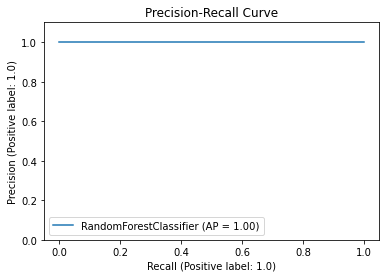

In [59]:
# Model evaluation - Precision Recall plot
disp_rfc_under = plot_precision_recall_curve(model_rfc_under, X_test, y_test)
disp_rfc_under.ax_.set_title('Precision-Recall Curve')
disp_rfc_under.ax_.set_ylim(0, 1.1)

# Oversampling - SMOTE

In [60]:
# Checking the shape of training dataset befor resampling
print(X_train.shape)
print(y_train.shape)

(900000, 7)
(900000,)


In [61]:
print('Original training dataset shape %s' % Counter(y_train))

Original training dataset shape Counter({0.0: 821300, 1.0: 78700})


In [62]:
# Using SMOTE to create an oversampled version of our dataset
sm = SMOTE(sampling_strategy='auto', random_state=3, k_neighbors=5)
X_train_os , y_train_os = sm.fit_resample(X_train, y_train)

In [63]:
print('Resampled training dataset shape %s' % Counter(y_train_os))

Resampled training dataset shape Counter({0.0: 821300, 1.0: 821300})


In [64]:
# Checking resampled traning data post scaling
print(X_train_os[0:3])
print(y_train_os[0:3])

[[-0.09927539 -0.18435468  0.13039206  0.36648113  1.36129066 -0.33457885
   0.73310066]
 [-0.060174    0.07942108 -0.50676744  0.36648113  1.36129066 -0.33457885
  -1.36406915]
 [-0.16039978 -0.03998452 -0.25923469  0.36648113 -0.73459697 -0.33457885
   0.73310066]]
[0. 0. 0.]


In [65]:
# Checking the shape of training dataset after resampling
print(X_train_os.shape)
print(y_train_os.shape)

(1642600, 7)
(1642600,)


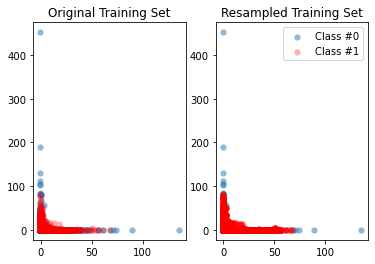

In [66]:
# Visualizing traning data before and after resampling
plt.subplot(1, 2, 1)
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label="Class #1", alpha=0.3, linewidth=0.15, c='r')
plt.title('Original Training Set')
plt.subplot(1, 2, 2)
plt.scatter(X_train_os[y_train_os == 0, 0], X_train_os[y_train_os == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(X_train_os[y_train_os == 1, 0], X_train_os[y_train_os == 1, 1], label="Class #1", alpha=0.3, linewidth=0.15, c='r')
plt.title('Resampled Training Set')
plt.legend()
plt.show()

## Logist Regression Model - Oversampling

In [67]:
# Logistic Regression training 
model_lgr_over = LogisticRegression()
model_lgr_over.fit(X_train_os, y_train_os)

LogisticRegression()

In [68]:
# Logistic Regression Prediction
y_pred_lgr_over = model_lgr_over.predict(X_test)

**Model Evaluation**

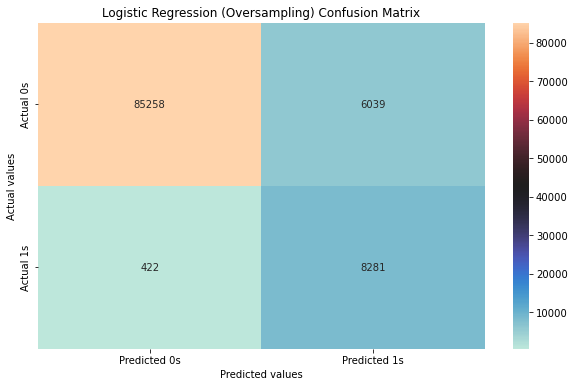

Logistic Regression (Oversampling)
True Negatives  :  85258
False Positives :  6039
False Negatives :  422
True Positives  :  8281
Sensitivity (Recall) :  0.9515109732276227
Specificity :  0.9338532481899734
Precision   :  0.5782821229050279
F1-Score    :  0.7193675889328064


In [69]:
# Model evaluation - Confusion matrix, Sensitivity, Specificity, Precision and F1-score
classifier_model_eval('Logistic Regression (Oversampling)', y_test, y_pred_lgr_over)

In [70]:
# Model evaluation - accuracy 
train_lgr_over_accuracy = model_lgr_over.score(X_train_os, y_train_os)
test_lgr_over_accuracy = model_lgr_over.score(X_test, y_test)
print("Logistic Regression (Oversampling):")
print("Training Accuracy - ", train_lgr_over_accuracy)
print("Testing Accuracy  - ", test_lgr_over_accuracy)

Logistic Regression (Oversampling):
Training Accuracy -  0.9411347863143796
Testing Accuracy  -  0.93539


In [71]:
# Model evaluation - AUC
training_lgr_over_AUC = roc_auc_score(y_train_os, model_lgr_over.predict_proba(X_train_os)[:, 1]) 
testing_lgr_over_AUC = roc_auc_score(y_test, model_lgr_over.predict_proba(X_test)[:, 1])
print("Logistic Regression (Oversampling):")
print("Training AUC : ", training_lgr_over_AUC)
print("Testing AUC  : ", testing_lgr_over_AUC)

Logistic Regression (Oversampling):
Training AUC :  0.9793692871819344
Testing AUC  :  0.9797926794226098


(0.0, 1.1)

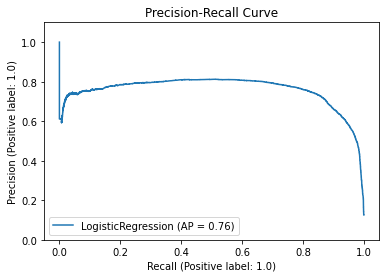

In [72]:
# Model evaluation - Precision Recall plot
disp_lgr_over = plot_precision_recall_curve(model_lgr_over, X_test, y_test)
disp_lgr_over.ax_.set_title('Precision-Recall Curve')
disp_lgr_over.ax_.set_ylim(0, 1.1)

### Decision Tree Classifier Model - Oversampling

In [73]:
# Decision tree training
model_dtc_over = DecisionTreeClassifier(criterion = 'entropy')
model_dtc_over.fit(X_train_os, y_train_os)

DecisionTreeClassifier(criterion='entropy')

In [74]:
# Decision Tree Prediction
y_pred_dtc_over = model_dtc_over.predict(X_test)

**Model Evaluation**

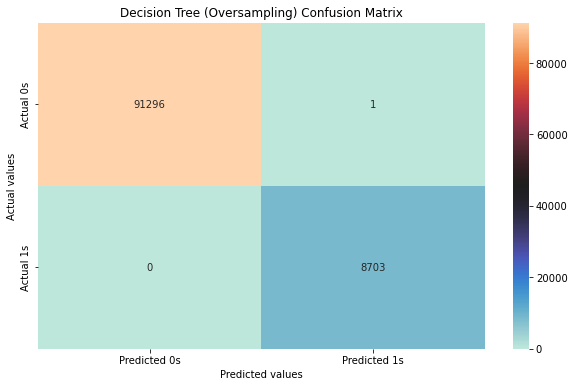

Decision Tree (Oversampling)
True Negatives  :  91296
False Positives :  1
False Negatives :  0
True Positives  :  8703
Sensitivity (Recall) :  1.0
Specificity :  0.9999890467375708
Precision   :  0.9998851102941176
F1-Score    :  0.999942551846958


In [75]:
# Model evaluation - Confusion matrix, Sensitivity, Specificity, Precision and F1-score
classifier_model_eval('Decision Tree (Oversampling)', y_test, y_pred_dtc_over)

In [76]:
# Model evaluation - accuracy 
train_dtc_over_accuracy = model_dtc_over.score(X_train_os, y_train_os)
test_dtc_over_accuracy = model_dtc_over.score(X_test, y_test)
print("Decision Tree (Oversampling):")
print("Training Accuracy - ", train_dtc_over_accuracy)
print("Testing Accuracy  - ", test_dtc_over_accuracy)

Decision Tree (Oversampling):
Training Accuracy -  1.0
Testing Accuracy  -  0.99999


In [77]:
# Model evaluation - AUC
training_dtc_over_AUC = roc_auc_score(y_train_os, model_dtc_over.predict_proba(X_train_os)[:, 1]) 
testing_dtc_over_AUC = roc_auc_score(y_test, model_dtc_over.predict_proba(X_test)[:, 1])
print("Decision Tree (Oversampling):")
print("Training AUC : ", training_dtc_over_AUC)
print("Testing AUC  : ", testing_dtc_over_AUC)

Decision Tree (Oversampling):
Training AUC :  1.0
Testing AUC  :  0.9999945233687855


(0.0, 1.1)

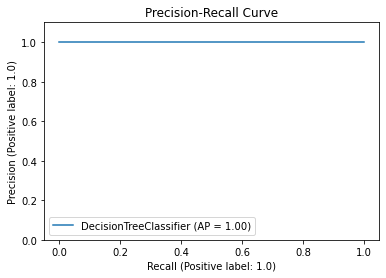

In [78]:
# Model evaluation - Precision Recall plot
disp_dtc_over = plot_precision_recall_curve(model_dtc_over, X_test, y_test)
disp_dtc_over.ax_.set_title('Precision-Recall Curve')
disp_dtc_over.ax_.set_ylim(0, 1.1)

### Random Forest Classifier Model - Oversampling

In [79]:
# Random Forest training
model_rfc_over = RandomForestClassifier(n_estimators = 21, criterion = 'entropy')
model_rfc_over.fit(X_train_os, y_train_os)

RandomForestClassifier(criterion='entropy', n_estimators=21)

In [80]:
# Random Forest Prediction
y_pred_rfc_over = model_rfc_over.predict(X_test)

**Model Evaluation**

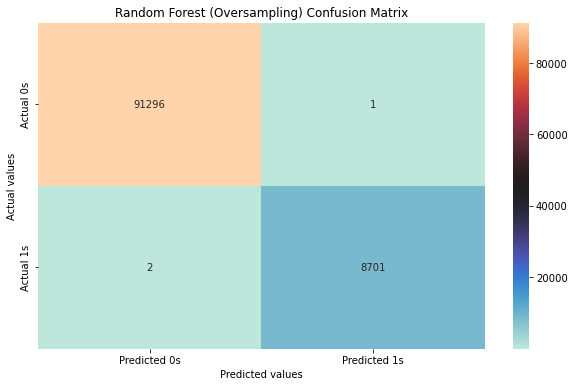

Random Forest (Oversampling)
True Negatives  :  91296
False Positives :  1
False Negatives :  2
True Positives  :  8701
Sensitivity (Recall) :  0.999770194185913
Specificity :  0.9999890467375708
Precision   :  0.9998850838887612
F1-Score    :  0.9998276357368572


In [81]:
# Model evaluation - Confusion matrix, Sensitivity, Specificity, Precision and F1-score
classifier_model_eval('Random Forest (Oversampling)', y_test, y_pred_rfc_over)

In [82]:
# Model evaluation - accuracy 
train_rfc_over_accuracy = model_rfc_over.score(X_train_os, y_train_os)
test_rfc_over_accuracy = model_rfc_over.score(X_test, y_test)
print("Random Forest (Oversampling):")
print("Training Accuracy - ", train_rfc_over_accuracy)
print("Testing Accuracy  - ", test_rfc_over_accuracy)

Random Forest (Oversampling):
Training Accuracy -  1.0
Testing Accuracy  -  0.99997


In [83]:
# Model evaluation - AUC
training_rfc_over_AUC = roc_auc_score(y_train_os, model_rfc_over.predict_proba(X_train_os)[:, 1]) 
testing_rfc_over_AUC = roc_auc_score(y_test, model_rfc_over.predict_proba(X_test)[:, 1])
print("Random Forest (Oversampling):")
print("Training AUC : ", training_rfc_over_AUC)
print("Testing AUC  : ", testing_rfc_over_AUC)

Random Forest (Oversampling):
Training AUC :  1.0
Testing AUC  :  0.9999999937071916


(0.0, 1.1)

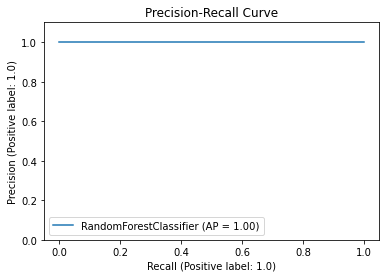

In [84]:
# Model evaluation - Precision Recall plot
disp_rfc_over = plot_precision_recall_curve(model_rfc_over, X_test, y_test)
disp_rfc_over.ax_.set_title('Precision-Recall Curve')
disp_rfc_over.ax_.set_ylim(0, 1.1)

## Model selection

**Accuracy** won’t be a reliable performance metric here due to highly imbalanced dataset.

Based on the use case we want to catch as much fraud as possible, so we want **lowest False Negatives** and **most optimized Recall or sensitivity**.

So, based on the evaluation metrices above the best model is - **Decision Tree Classifier model trained on Over sampled data**

```
Accuracy = 99.999% 
False Negatives = 0
False Positives = 1
Recall = 1.0
Precision = 0.9998851102941176
F1-Score = 0.999942551846958
```


### Ways of improving the model

    •	We can optimize model parameters to get better predictions.
            o Using Grid Search CV for model selection with optimal parameter values.
    •	Try with different splitting % for testing and training data.
    •	Try using other ensemble models like XGBoost.
    •	Try different feature scaling techniques.
            o Min-Max Normalization
            o Z-score Normalization
    •	Try to handle outliers.
